<a href="https://colab.research.google.com/github/mkxdxdxd/CSED499I/blob/main/exp2_final_learnable_parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip show javalang
!pip install javalang
import os

#1. Settings

### 1) import required

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/dataset.pkl')

In [5]:
print(data.columns)

Index(['SubjectID', 'AssignmentID', 'ProblemID', 'CodeStateID', 'Score_x',
       'Code', 'Code-ast', 'code-astnn', 'code-embedding', 'Score_y',
       'embedding', 'astnn', 'prompt', 'prompt-embedding', 'input'],
      dtype='object')


### 2) Hyperparmeters

In [10]:
input_size=768
hidden_size=100
num_layers=3
output_size=200
bidirectional=False
batch_first=True

In [11]:
learning_rate = 1e-2
batch_size = 35
epochs = 1500

### 3) Data preprocessing

In [7]:
data_stu_code = data[['SubjectID', 'prompt-embedding', 'embedding']]
print(data_stu_code)

                              SubjectID  \
0      04c32d4d95425f73b3a1d6502aed4d48   
1      04c32d4d95425f73b3a1d6502aed4d48   
2      04c32d4d95425f73b3a1d6502aed4d48   
3      04c32d4d95425f73b3a1d6502aed4d48   
4      04c32d4d95425f73b3a1d6502aed4d48   
...                                 ...   
39791  ffb72475a81de0e95b910ffad039f5c2   
39792  ffb72475a81de0e95b910ffad039f5c2   
39793  ffb72475a81de0e95b910ffad039f5c2   
39794  ffb72475a81de0e95b910ffad039f5c2   
39795  ffb72475a81de0e95b910ffad039f5c2   

                                        prompt-embedding  \
0      [0.007758622, -0.02058616, 0.051114812, 0.0035...   
1      [0.0004377277, -0.025701463, 0.05109195, 0.003...   
2      [0.0004377277, -0.025701463, 0.05109195, 0.003...   
3      [0.019149723, -0.0023263248, 0.052457552, 0.01...   
4      [0.019149723, -0.0023263248, 0.052457552, 0.01...   
...                                                  ...   
39791  [-0.010156284, -0.011037813, 0.0460355, 0.0212...   
397

In [8]:
grouped = data_stu_code.groupby('SubjectID')

In [9]:
students_data ={}
for subject_id, group in grouped:
    #print(group['prompt-embedding'])
    embeddings = group['prompt-embedding'].tolist()  # Converting string representations of lists back to lists
    labels = group['embedding'].tolist()

    embeddings = np.array(embeddings, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    students_data[subject_id] = (embeddings, labels)

# 2. Training

### 1) Model

In [12]:
#2-2; learnable parameter
# class LSTMModel(nn.Module):
#   def __init__(self, input_size, hidden_size, num_layers, output_size):
#      super().__init__()
#      self.input_size, self.hidden_size, self.output_size = input_size, hidden_size, output_size
#      self.num_layers = num_layers
#      self.num_directions = 2 if bidirectional else 1
#      self.lstm = nn.LSTM(input_size=self.input_size, hidden_size = self.hidden_size, num_layers=self.num_layers, bidirectional=bidirectional, batch_first=True)
#      self.linear = nn.Linear(self.hidden_size * self.num_directions, output_size)

#      #define learnable parameters
#      self.h0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.hidden_size))
#      self.c0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.hidden_size))

#   def forward(self, x):
#     x, _ = self.lstm(x, (self.h0, self.c0))
#     output = self.linear(x)
#     return output

#2-1: h0 set to
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
     super().__init__()
     self.input_size, self.hidden_size, self.output_size = input_size, hidden_size, output_size
     self.num_layers = num_layers
     self.num_directions = 2 if bidirectional else 1
     self.lstm = nn.LSTM(input_size=self.input_size, hidden_size = self.hidden_size, num_layers=self.num_layers, bidirectional=bidirectional, batch_first=True)
     self.linear = nn.Linear(self.hidden_size * self.num_directions, output_size)

  def forward(self, x):
    x, _ = self.lstm(x)
    output = self.linear(x)
    return output

### 2) Training loop

In [13]:
val_loss_history = {}
train_loss_history = {}
test_loss_history = {}
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # prediction and loss calculation
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            if student_id not in train_loss_history:
              train_loss_history[student_id] = []
            train_loss_history[student_id].append(loss)
            print(f"Train loss: {loss:>8f}")


def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_fn(pred, y).item() #calculate val loss

    val_loss /= num_batches
    if student_id not in val_loss_history:
      val_loss_history[student_id] = []
    val_loss_history[student_id].append(val_loss)
    print(f"val loss: {val_loss:>8f} ")

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
      for X, y in dataloader:
          pred = model(X)
          test_loss += loss_fn(pred, y).item() #calculate val loss

  test_loss /= num_batches
  if student_id not in test_loss_history:
    test_loss_history[student_id] = []
  test_loss_history[student_id].append(test_loss)
  print(f"test loss: {test_loss:>8f} \n")

### 3) Training

In [14]:
model = {}
test_loss_early_stopping = {}
initial_h0 = {}
initial_c0 = {}
all_h0 = {}
all_c0 = {}
for student_id, _ in students_data.items():
  one_student = students_data[student_id]
  X = torch.tensor(one_student[0])
  y = torch.tensor(one_student[1])

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #training:test = 8:2
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.2, shuffle=False) #training:valid = 8:2 again

  X_train = X_train.unsqueeze(0)  # Add a batch dimension
  X_test = X_test.unsqueeze(0)
  X_val = X_val.unsqueeze(0)

  y_train = y_train.unsqueeze(0)
  y_test = y_test.unsqueeze(0)
  y_val = y_val.unsqueeze(0)

  train_dataset = TensorDataset(X_train, y_train)
  test_dataset = TensorDataset(X_test, y_test)
  valid_dataset = TensorDataset(X_val, y_val)

  dataloaders = {}
  dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
  dataloaders['test'] = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  dataloaders['valid'] = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model[student_id] = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
  loss_func = nn.MSELoss()
  optimizer = torch.optim.Adam(model[student_id].parameters(), lr=learning_rate)

  for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print(f"Student_id: {student_id}")
    train_loop(dataloaders['train'], model[student_id], loss_func, optimizer)
    val_loop(dataloaders['valid'], model[student_id], loss_func)
    test_loop(dataloaders['test'], model[student_id], loss_func)
    # if student_id not in all_h0:
    #   all_h0[student_id] = []
    # all_h0[student_id].append(model[student_id].h0)
    # if student_id not in all_c0:
    #   all_c0[student_id] = []
    # all_c0[student_id].append(model[student_id].c0)
  print("Done!")

  index_min = min(range(len(val_loss_history[student_id])), key=val_loss_history[student_id].__getitem__)
  # print("Minimum for validation set")
  # print("epoch: ", index_min+1, "value: ", min(val_loss_history[student_id]))
  # print("test loss: ", test_loss_history[student_id][index_min]) #test loss for such epoch
  test_loss_early_stopping[student_id] = test_loss_history[student_id][index_min]
  # initial_h0[student_id] = all_h0[student_id][index_min]
  # initial_c0[student_id] = all_c0[student_id][index_min]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

Epoch 787
-------------------------------
Student_id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.005021
val loss: 0.159309 
test loss: 0.167347 

Epoch 788
-------------------------------
Student_id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.005097
val loss: 0.160065 
test loss: 0.165524 

Epoch 789
-------------------------------
Student_id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.005059
val loss: 0.159572 
test loss: 0.166457 

Epoch 790
-------------------------------
Student_id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.004968
val loss: 0.159459 
test loss: 0.167527 

Epoch 791
-------------------------------
Student_id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.005092
val loss: 0.161105 
test loss: 0.164413 

Epoch 792
-------------------------------
Student_id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.005216
val loss: 0.159479 
test loss: 0.166590 

Epoch 793
-------------------------------
Student_id: ffb72475a

### 4) Learning curve

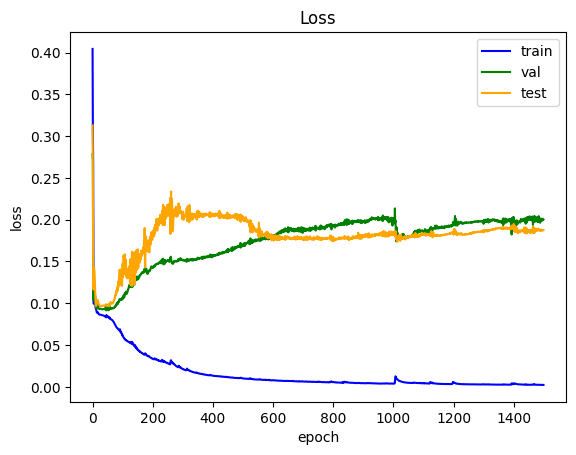

{'04c32d4d95425f73b3a1d6502aed4d48': 0.09893966466188431, '0503bf609757acf2e75aa8cbc0d8323b': 0.11750497668981552, '06d801cb636235b298c40029ad9921e7': 0.1143074780702591, '07ae4cca3f90a49347ccb5c1a82ff46f': 0.11013185232877731, '07d34e2419c61216a85a2156b2cf8ae4': 0.08843528479337692, '08fcb5ead4e963a6f0bbdbc971f4a3ee': 0.09318895637989044, '0a7ff96e4fa7c92a13ccab013d580930': 0.12643079459667206, '0aaf61723a352ba7ea1be4502df85765': 0.10266868770122528, '0ae12dc3676bc09a35fe6ed96926a6b5': 0.10424462705850601, '0bbeaf0242180c8abffb2b8dada5a9e4': 0.07569396495819092, '0e2cb039638d9ab503d33105ed343d7e': 0.08463814109563828, '0ee7e71061cf860ccf3b29c6823c7971': 0.08557145297527313, '115c51eb37365df2d4f4e2482b964822': 0.09277845174074173, '11d8ffa1c1cb79e22b6d94667d3847d9': 0.096324622631073, '1379719828be9ee6b08ca64edb818e2b': 0.10788490623235703, '138a14eaf4a8c188a6c41cafd9400a30': 0.103876493871212, '13dfe127c6d40641c7ad9fd60ef8701d': 0.09161264449357986, '14b094aef5d2df47fa9dd009b2d6ecb1':

In [15]:
#Let's draw a learning curve like below.
student_id = "04c32d4d95425f73b3a1d6502aed4d48"
plt.plot(train_loss_history[student_id], label='train', color='blue')
plt.plot(val_loss_history[student_id], label='val', color='green')
plt.plot(test_loss_history[student_id], label='test', color='orange')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()
plt.show()

# index_min = min(range(len(val_loss_history)), key=val_loss_history.__getitem__)
# print("Minimum for validation set")
# print("epoch: ", index_min+1, "value: ", min(val_loss_history))
# print("test loss: ", test_loss_history[index_min]) #test loss for such epoch

print(test_loss_early_stopping)

### 5) download data

In [16]:
lstm_test_loss = pd.DataFrame(list(test_loss_early_stopping.items()), columns=['SubjectID', 'Test loss'])

from google.colab import files
lstm_test_loss.to_csv('lstm_test_loss_h0=0.csv')

files.download('lstm_test_loss_h0=0.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>